In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

%matplotlib inline  

/home/wca3rt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Step 0: Load The Data

In [2]:
import pickle

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

In [3]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
import csv

with open('./signnames.csv', 'r') as csvfile:
   sign_names  =  {int(line[0]) : line[1] for line in csv.reader(csvfile) if line[0]!='ClassId'}

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
occurences = dict(zip(unique, counts))

print("%10s %50s %15s" % ('Classid:', 'Class:', 'Occurences:'))
for cl in sorted(occurences, key=occurences.get, reverse=True):
    print("%10s %50s %15s" % (cl, sign_names[cl], occurences[cl]))

  Classid:                                             Class:     Occurences:
         2                               Speed limit (50km/h)            2010
         1                               Speed limit (30km/h)            1980
        13                                              Yield            1920
        12                                      Priority road            1890
        38                                         Keep right            1860
        10       No passing for vehicles over 3.5 metric tons            1800
         4                               Speed limit (70km/h)            1770
         5                               Speed limit (80km/h)            1650
        25                                          Road work            1350
         9                                         No passing            1320
         7                              Speed limit (100km/h)            1290
         3                               Speed limit (60km/h)   

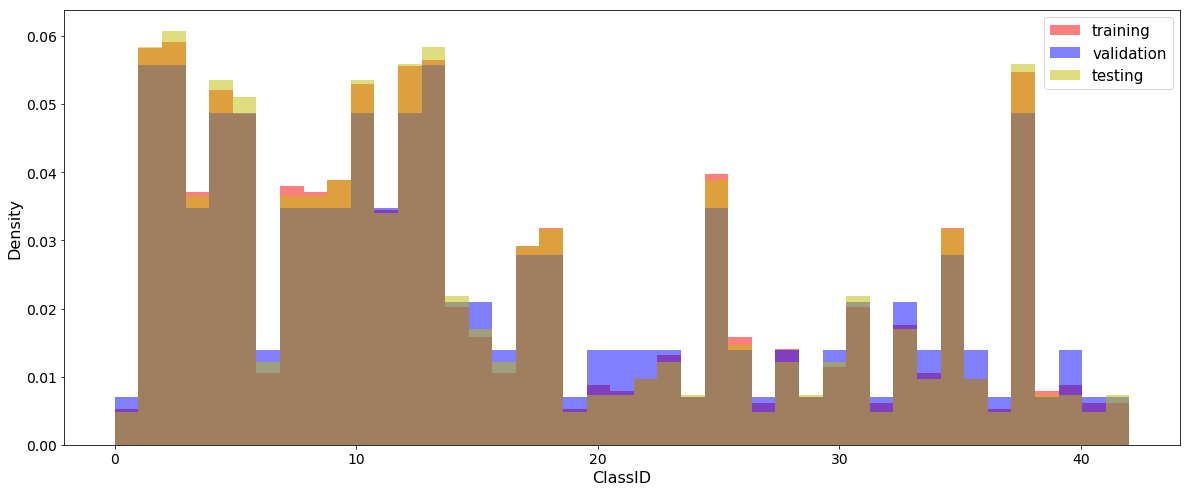

In [6]:
fig = plt.figure(figsize=(20, 8))

plt.hist(y_train, n_classes, histtype='stepfilled', facecolor='r', alpha=0.5, density=True, label='training')
plt.hist(y_valid, n_classes, histtype='stepfilled', facecolor='b', alpha=0.5, density=True, label='validation')
plt.hist(y_test, n_classes, histtype='stepfilled', facecolor='y', alpha=0.5, density=True, label='testing');
plt.xlabel("ClassID", fontsize=16)  
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.legend(fontsize=15);

Class: Speed limit (20km/h)   Classid: 0   Number of instances: 180


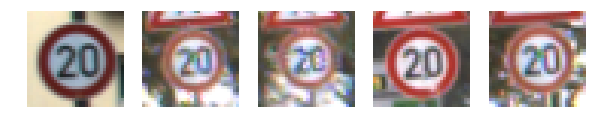

Class: Speed limit (30km/h)   Classid: 1   Number of instances: 1980


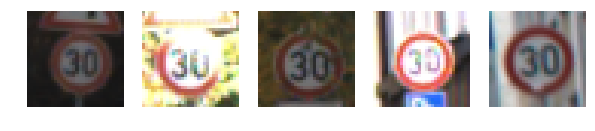

Class: Speed limit (50km/h)   Classid: 2   Number of instances: 2010


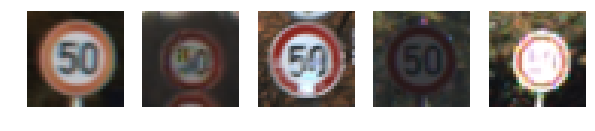

Class: Speed limit (60km/h)   Classid: 3   Number of instances: 1260


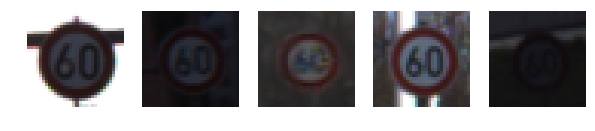

Class: Speed limit (70km/h)   Classid: 4   Number of instances: 1770


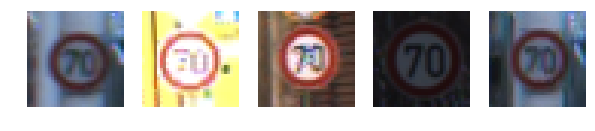

In [7]:
n_examples_per_class = 5

for cl in list(sign_names.keys())[:5]:  #not correct yet! classes are still imbalanced
    indices = (y_train == cl)
    no_current_class = len(X_train[indices])
    print('Class:', sign_names[cl], '  Classid:', cl, '  Number of instances:', no_current_class)
    fig = plt.figure(figsize = (10, 5))
    for idx, idx_img in enumerate(np.random.randint(0, no_current_class, n_examples_per_class)):
        ax = fig.add_subplot(1, n_examples_per_class, idx + 1)
        img = X_train[indices][idx_img]
        plt.axis('off')
        plt.imshow(img)    
    plt.show()   

## Step 2: Design and Test a Model Architecture

In [8]:
import cv2

def grayscale(img):
    "Applies the Grayscale transform according to 0.299*R+0.587*G+0.114*B."
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    

def pre_process(X):
    """Preprocess images: grayscale, normalize and reshape.
    
    Args:
    X     -- data set with format (m, width, height, 3)
    """
    assert len(X.shape)==4
    
    _, width, height, channels = X.shape
    X = [grayscale(image) for image in X]
    # apply histogram equalization (image processing technique to improve contrast)
    clahe = cv2.createCLAHE(tileGridSize=(2,2), clipLimit=20.0)
    X = [clahe.apply(image) for image in X]
    # input node of tensorflow graph expects inputs of shape (None, x_dim, y_dim, channels)
    # in case of grayscale image one has to add the last dimension with channels=1
    X = [image.reshape(width, height, 1) / 255. for image in X]
    return np.array(X, dtype=np.float32)

X_train_pre = pre_process(X_train)
X_valid_pre = pre_process(X_valid)
X_test_pre = pre_process(X_test)

# dump preprocessed data because preprocessing does requiere cv2 which is not installed
# on  GPU of AWS. Use pickled files instead of orginal file and do the preprocessing locally.
#pickle.dump(X_train_pre, open('./data/x_train_pre_processed.pkl', 'wb', -1))
#pickle.dump(X_valid_pre, open('./data/x_valid_pre_processed.pkl', 'wb', -1))
#pickle.dump(X_test_pre, open('./data/x_test_pre_processed.pkl', 'wb', -1))

In [9]:
# load pickeled files: start to execute notebook at this point if on GPU
#with open('./data/x_train_pre_processed.pkl', mode='rb') as f:
#    X_train_pre = pickle.load(f)
#with open('./data/x_valid_pre_processed.pkl', mode='rb') as f:
#    X_valid_pre = pickle.load(f)
#with open('./data/x_test_pre_processed.pkl', mode='rb') as f:
#    X_test_pre = pickle.load(f)

In [10]:
from skimage import transform
import math

def augmentation(image, max_shift = 2, max_angle = 10, max_zoom = 2):
    """Shift, rotate and zoom randomly. Used for data augmentation.
    
    Args:
    image     -- original image
    max_shift -- image is shifted randomly by pixels in range [-max_shift, max_shift]
    max_angle -- rotate image randomly by angle in range [-max_angle, max_angle]
    max_zoom  -- zoom randomly by a number of pixels in range [0, max_zoom]
    """
    width_initial, height_inital, channel_initial = image.shape
    
    # rotate image by an angle between [-max_angle, max_angle]
    # https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders/16778797
    angle = np.random.randint(-max_angle, max_angle + 1)
    image = rotate_and_crop_image(image, angle)
    # if channel initial = 1:
    # reshape image from to (width_initial, height_inital) to (width_initial, height_inital, channel_initial)
    image = image.reshape((width_initial, height_inital, channel_initial))
    
    # zoom randomly by shrinking the image (without changing the center position of the traffic sign)
    # and resizing it to its original size
    pixel_shrink = np.random.randint(0, max_zoom + 1)
    x0 = pixel_shrink
    y0 = pixel_shrink
    x1 = width_initial - pixel_shrink
    y1 = height_inital - pixel_shrink
    image = image[y0:y1, x0:x1]
    image = cv2.resize(image, dsize=(width_initial, height_inital), interpolation=cv2.INTER_CUBIC)
    #image = transform.resize(image, (width_initial, height_inital), mode='reflect')
 
    # shift image randomly in horizontal and vertical direction 
    pixel_shift_ver = np.random.randint(-max_shift, max_shift + 1)
    pixel_shift_hor = np.random.randint(-max_shift, max_shift + 1)
    x0, x1 = bounding_box_shift(pixel_shift_ver, width_initial)
    y0, y1 = bounding_box_shift(pixel_shift_hor, height_inital)
    image = image[y0:y1, x0:x1]
    image = cv2.resize(image, dsize=(width_initial, height_inital), interpolation=cv2.INTER_CUBIC)
    #image = transform.resize(image, (width_initial, height_inital), mode='reflect')
    image = image.reshape((width_initial, height_inital, channel_initial))
    
    return image


def bounding_box_shift(pixel_shift, dim_initial):
    """Compute coordinates to shift image.transform
    
    Args:
    pixel_shift -- shift in pixels
    dim_initial -- size of original image in direction of shift
    """
    if pixel_shift < 0:
        return abs(pixel_shift), dim_initial
    else:
        return 0, dim_initial- pixel_shift
    return 0, dim_initial
    
    
def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = math.ceil(image_center[0] - width * 0.5)
    x2 = math.floor(image_center[0] + width * 0.5)
    y1 = math.ceil(image_center[1] - height * 0.5)
    y2 = math.floor(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]


def rotate_and_crop_image(image, angle):
    image_width, image_height = image.shape[:2]
    image_orig = np.copy(image)
    image_rotated = rotate_image(image, angle)
    image_rotated_cropped = crop_around_center(
        image_rotated,
            *largest_rotated_rect(
                image_width,
                image_height,
                math.radians(angle)
            )
        )
    image_rotated_cropped = cv2.resize(image_rotated_cropped, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    #image_rotated_cropped = transform.resize(image_rotated_cropped, (image_width, image_height), mode='reflect')
    return image_rotated_cropped

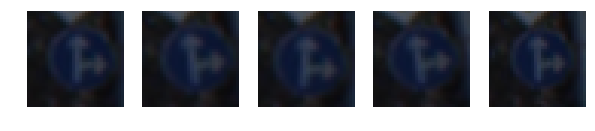

In [11]:
img = X_train[1000]
img_aug = [augmentation(img) for _ in range(5)]

fig = plt.figure(figsize = (10, 5))
for idx, img in enumerate(img_aug):
    ax = fig.add_subplot(1, len(img_aug), idx + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')    
plt.show()   

In [12]:
def prepare_batch(X, y, batch_size, uniform=True, augment=True):
    """Return a batch of given size with data augmentation.
    
    Note: This is actually no real mini-batch implementation.
    In principle the function might return for each call the same data set.
    However, in practice the difference between real mini-batch and this implementation
    is minor.
    
    Image is always normalized to range [0:1].
    
    Args:
    X            -- data set of images
    y            -- class labels
    batch_size   -- batch_size of batch
    uniform      -- assume unform distribution for all classes
    augment      -- activate data augmentation 
    """
    unique, counts = np.unique(y, return_counts=True)
    occurences = dict(zip(unique, counts))
    # this additional normalization seems to be necessary to get np.random.choice to work
    # increase the probability of classes which occur rarely in the data set such that the 
    # distribution of instances per classes is approximately uniform
    p = np.array(list(occurences.values()))
    p = 1 / p
    p = p / p.sum()
    X_batch, y_batch = [], []
    for _ in range(batch_size):
        if uniform:
            cl = np.random.choice(list(occurences.keys()), p=p)
        else:
            cl = np.random.choice(list(occurences.keys()))
        indices = (y == cl)
        X_cl = X[indices]
        idx = np.random.randint(0, len(X_cl))
        X_batch.append(X_cl[idx])
        y_batch.append(cl)
    if augment:
        # intensity values are not between 0 and 1 because of interpolation
        X_batch = [augmentation(image) for image in X_batch] 
     
    return np.asarray(X_batch, dtype=np.float32), np.asarray(y_batch, dtype=np.int32)


def status(n_epochs, n_batches):
    """Return function which returns string with status information (e.g. remaining time)"""
    status.time_tot = 0
    status.curr_iter = 0
    status.n_batches = n_batches
    status.n_epochs = n_epochs
    status.n_iter = n_batches*n_epochs
    def _f(time_diff, epoch, batch):
        status.time_tot = status.time_tot + time_diff
        status.curr_iter = status.curr_iter + 1
        mean_time_per_batch = status.time_tot/status.curr_iter
        str_out = "Epochs: %s/%s \tIterations: %s/%s \tTime per batch: %s s \tRemaining time: %s s" % (
                    epoch, status.n_epochs, 
                    status.curr_iter, status.n_iter, 
                    round(mean_time_per_batch, 4),
                    round((status.n_iter - status.curr_iter)*mean_time_per_batch, 4))
        return str_out
    return _f    

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError 
import time

tf.reset_default_graph()

class CNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.0001, batch_size=20, activation=tf.nn.elu, 
                 initializer=tf.contrib.layers.variance_scaling_initializer(),
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the CNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate 
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None
    
    def _cnn(self, inputs): 
        """Build the actual CNN."""
        with tf.name_scope('conv_layers'):
            # input: 32x32x1  
            # layer: 30x30x32
            out = tf.layers.conv2d(inputs, filters=32, kernel_size=5, 
                                   strides=[1, 1], padding="SAME", 
                                   activation=tf.nn.relu, name='conv_layer1')
            # layer: 15x15x32
            out = tf.nn.max_pool(out,
                                 ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1],
                                 padding='VALID',
                                 name='pooling_layer1')
            # feed this output to classifier after another max-pooling step
            out_stage1 = tf.nn.max_pool(out,
                                       ksize=[1, 4, 4, 1],
                                       strides=[1, 2, 2, 1],
                                       padding='VALID',
                                       name='pooling_stage1')
            if self.dropout_rate:
                out = tf.layers.dropout(out, 0.25, training=self._training, name='dropout1')

            
            # layer: 13x13x64
            out = tf.layers.conv2d(out, filters=64, kernel_size=5, 
                                   strides=[1, 1], padding="SAME", 
                                   activation=tf.nn.relu, name='conv_layer2')  
            # layer: 6x6x64
            out = tf.nn.max_pool(out,
                                 ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1],
                                 padding='VALID',
                                 name='pooling_layer2')
            if self.dropout_rate:
                out = tf.layers.dropout(out, 0.25, training=self._training, name='dropout2')

            
            # layer: 4x4x128            
            out = tf.layers.conv2d(out, filters=128, kernel_size=5, 
                                   strides=[1, 1], padding="SAME", 
                                   activation=tf.nn.relu, name='conv_layer3') 
            # layer: 2x2x128
            out = tf.nn.max_pool(out,
                                 ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1],
                                 padding='VALID',
                                 name='pooling_layer3')
            if self.dropout_rate:
                out = tf.layers.dropout(out, 0.25, training=self._training, name='dropout3')
            # reshape out in a tensor of shape (m, n_neurons_layer, 1)
            m, h, w, d = out.get_shape()
            out = tf.reshape(out, [-1, h*w*d])   # 512 neurons
            # reshape first stage output
            m, h, w, d = out_stage1.get_shape()
            out_stage1 = tf.reshape(out_stage1, [-1, h*w*d])
            out = tf.concat([out, out_stage1], 1)
        with tf.name_scope('classifier'):
            out = tf.layers.dense(out, 120, activation=tf.nn.relu, 
                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(0.0001),
                                  name='fully_connected_1')
            if self.dropout_rate:
                out = tf.layers.dropout(out, 0.5, training=self._training, name='dropout4')
            out = tf.layers.dense(out, 84, activation=tf.nn.relu, 
                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(0.0001),
                                  name='fully_connected_2')
            if self.dropout_rate:
                out = tf.layers.dropout(out, 0.5, training=self._training, name='dropout5')
       
        return out

    def _build_graph(self, width, height, channels, n_outputs):
        """Build graph of model.
        
        Important nodes which are evaluated later on are assigned to private instance variables for easy access
        by other methods.
        """
        if self.random_state is not None: 
            tf.set_random_seed(self.random_state) 
            np.random.seed(self.random_state)
            
        X = tf.placeholder(tf.float32, shape=(None, height, width, channels), name='X')
        y = tf.placeholder(tf.int64, shape=(None), name='y')
        
        # set training variable for controlling batch_norm and dropout algorithms
        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training') 
        else:
            self._training = None 
        
        with tf.variable_scope("cnn"):
            cnn = self._cnn(X)
            logits = tf.layers.dense(cnn, n_outputs, kernel_initializer=self.initializer, name="logits")
            Y_proba = tf.nn.softmax(logits, name="Y_proba")
        with tf.name_scope("train"):
            # it is at this point where we get a relationship between a class label and a neuron of the output layer
            # y has to be in range: [0, no_classes-1]
            # before this step no output neuron is assigned to a class
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
            base_loss = tf.reduce_mean(xentropy, name='base_loss')
            # reg loss:
            reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            loss = tf.add_n([base_loss] + reg_loss, name='loss')
            optimizer = self.optimizer_class(learning_rate=self.learning_rate)
            training_op = optimizer.minimize(loss, name='training_op')
        with tf.name_scope("eval"):
            y_pred = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(y_pred, tf.float32), name='accuracy')
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("saver"):
            saver = tf.train.Saver()               

        self._X, self._y = X, y
        self._loss, self._Y_proba = loss, Y_proba
        self._accuracy, self._training_op = accuracy, training_op
        self._init, self._saver = init, saver
        
    def close_session(self):
        if self._session:
            self._session.close_session()
                
    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name : value for gvar, value in zip(gvars, self._session.run(gvars))}
        
    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk).
        
        model_params is a dictonary which contians values for alle tf.Variable operations of graph.
        Function assigns these values to all variables.
        
        Args:
        model_params -- Dictonary as return by _get_model_params {op_name : value, ...}
        """
        op_names = list(model_params.keys())
        # first we need a handle the assignment operations of all tf.Variables
        op_handles = {op_name : self._graph.get_operation_by_name(op_name + '/Assign') for op_name in op_names}
        # next we need a handle on the second Input of these assignment operation
        op_input_handles = {op_name : op_handle.inputs[1] for op_name, op_handle in op_handles.items()}
        # lastly, we setup the feed_dict we pass to the run operation
        feed_dict = {op_input_handles[op_name] : model_params[op_name]   for op_name in op_names}
        # you can pass a dict to run (evaluates automatically the values). Here a list of operations
        # would have been sufficient as well. Note: You have to run the Assignment-Node not its second input.
        self._session.run(op_handles, feed_dict=feed_dict)         
        
    def fit(self, X, y, n_epochs=10, X_valid=None, y_valid=None, uniform=True, augment=True, augmentation_factor=1):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping.
        
        Args: 
        X  -- training set in format (m, width, height, channels)
        y  -- labels
        n_epochs -- number of epochs
        X_valid -- validation set (m, width, height, channels)
        y_valid -- labels of validation set
        uniform -- assume uniform distribution of classes
        augment -- if true data augmentation is activated
        augmentation_factor -- size of the augmentation data set with respect to the 
        """
        
        self.close_session()
        
        # convert class labels of y to contigous index in range [0, no_classes-1]
        # self.classes is a lookup table to restore the original y
        self.classes_, y = np.unique(y, return_inverse=True)
        
        # infer number of input and output neurons from data
        _, width, height, channels = X.shape
        n_outputs = len(self.classes_)
        
        # build graph 
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(width, height, channels, n_outputs)
            # extra operations for batch normalization (need to be updated after every iteration)
            if self.batch_norm_momentum:
                extra_ops_batch = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
        
        # variables which are needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None  
        
        # start the actual training of the model
        # start session and select graph to run
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            n_batches = (len(X) // self.batch_size)*augmentation_factor
            str_status = status(n_epochs, n_batches)
            for epoch in range(n_epochs):            
                for i in range(n_batches):
                    t0 = time.time()
                    X_batch, y_batch = prepare_batch(X, y, self.batch_size, uniform=uniform, augment=augment) 
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self.batch_norm_momentum or (self._training is not None):
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    # in case of batch_norm update extra operations
                    if self.batch_norm_momentum:
                        sess.run(extra_ops_batch, feed_dict=feed_dict)
                    t1 = time.time()
                    print('\r' + str_status(t1-t0, epoch, i), end="")
                # early stopping if X_valid and y_valid are given
                if (X_valid is not None) and (y_valid is not None):
                    loss_valid, acc_valid = self.loss_and_accuracy(X_valid, y_valid, batch_size=256)
                    # train info missing to determine if model suffers from overfitting?
                    if best_loss > loss_valid:
                        checks_without_progress = 0
                        best_loss = loss_valid
                        best_params = self._get_model_params()
                    else:
                        if checks_without_progress > max_checks_without_progress:
                            print()
                            print('Early stopping!')
                            break
                        checks_without_progress += 1
                    print()
                    print(epoch, '\tloss_valid:', loss_valid, '\tbest_loss:', best_loss, '\tacc_valid', acc_valid)
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy], 
                                                      feed_dict={self._X: X_batch, self._y : y_batch}) 
                    print()
                    print(epoch, '\tLast training batch loss:', loss_train, 
                          '\tLast training batch accuracy', acc_train)
            # in case of early stopping: restore parameters of winner snapshot
            if best_params is not None:
                self._restore_model_params(best_params)
            return self    
                       
    def predict_proba(self, X):
        # self._session has only a value if fit method has been run   p
        if not self._session:
            raise NotFittedError('Fit method of this instance has not yet been run.')
        # no need to pass self._training = False because this is the default value
        # self._X is a handle on the placeholder node of X
        return self._session.run(self._Y_proba, feed_dict = {self._X: X})

    def predict(self, X, test_batch_size=200):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        # self.classes_ is just a lookup table to get the class label for the index 
        # in the contiguous range [0, no_classes-1]
        # predict is supposed to return an array according to sklearn convention
        return np.array([self.classes_[class_idx] 
                         for class_idx in class_indices], np.int32)
    
    def loss_and_accuracy(self, X, y, batch_size=256):
        """Compute loss and accuracy for each batch and average the results.  
        
        Useful if X is very large.
        
        Args:
        X          -- full data set
        y          -- labels
        batch_size -- size of each batch
        """
        if not self._session:
            raise NotFittedError('Fit method of this instance has not yet been run.')
             
        n_batch_size = len(X) // batch_size
        X_batches = np.array_split(X, n_batch_size)
        y_batches = np.array_split(y, n_batch_size)
        results = [ self._session.run([self._loss, self._accuracy], 
                             feed_dict={self._X: X_batch, self._y: y_batch})
                    for X_batch, y_batch in zip(X_batches, y_batches) ]
        results = np.mean(results, axis=0)
                
        return results[0], results[1]
            
    def save(self, path):
        """Save all tf.Variable operations of session to disk."""
        self._saver.save(self._session, path)


In [14]:
dnn_clf = CNNClassifier(batch_size=512, dropout_rate=0.5, learning_rate=0.001)
dnn_clf.fit(X_train_pre, y_train, 500, X_valid_pre, y_valid, uniform=False, augment=False, augmentation_factor=1)
dnn_clf.loss_and_accuracy(X_train_pre, y_train, 128)
dnn_clf.loss_and_accuracy(X_test_pre, y_test, 128)

Epochs: 0/500 	Iterations: 67/33500 	Time per batch: 1.8869 s 	Remaining time: 63085.458 ss
0 	loss_valid: 3.7451813 	best_loss: 3.7451813 	acc_valid 0.040585965
Epochs: 1/500 	Iterations: 134/33500 	Time per batch: 1.8725 s 	Remaining time: 62476.5088 s
1 	loss_valid: 3.2252302 	best_loss: 3.2252302 	acc_valid 0.12787873
Epochs: 2/500 	Iterations: 201/33500 	Time per batch: 1.8485 s 	Remaining time: 61553.3097 s
2 	loss_valid: 2.5084076 	best_loss: 2.5084076 	acc_valid 0.2152597
Epochs: 3/500 	Iterations: 215/33500 	Time per batch: 1.8483 s 	Remaining time: 61521.6289 s

KeyboardInterrupt: 

In [ ]:
"""
# (0.17089884, 0.9684105)
- l1/l2 regularization
- equalization
- do it like YanLeChun

- write for GPU

(- normal mini-batch)
- augmentation
- (batch norm?)
- vary batch_size
- full optimization

- axis==1 correct in function concat?
"""

In [ ]:
dnn_clf.loss_and_accuracy(X_train_pre, y_train, 128)
